**EXP1 Predicitng Missing Cell-Types from Bulks using Non-Negative Least Squares regression Residual**

*This file includes EXP1 specifics (outlined below), as well as the data preprocessing, QC, and creates the pseudobulks used in other experiments.*

Data downloaded from: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE176171
Original paper: https://pubmed.ncbi.nlm.nih.gov/35296864/ PMID: 35296864
Source name	omental adipose tissue
Organism	Homo sapiens
Characteristics	tissue: white adipose tissue
Sex: female
age: 29y
bmi: 49.3
surgery: VSG

Experimental Details: https://docs.google.com/spreadsheets/d/1fMV_URm95iPh-6rew-Be27I1-i8PNgGNWi2D_UO2V9w/edit#gid=0
Summary: Preprocessing single-nucleus data from adipose tissue extracted during surgery. Creating 1000 realistic-proportions pseudobulks in 10 separate files with each file containing 1000 bulks. Then, removing 1, 4, and 12 celltypes from each patient-file. Celltypes removed are chosen at random.

*This file can be run one kernel at a time, or all at once*

In [221]:
# import the dependencies
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
sys.path.insert(1, '../../../../../')

from functions import sn_sc_preprocess
from functions import validation_plotting as vp
from importlib import reload
reload(sn_sc_preprocess)
reload(vp)
# general imports
import warnings
import numpy as np
from numpy import random
import pandas as pd
import scanpy as sc
from anndata import AnnData as ad
from tabulate import tabulate

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

import scipy as sp
from scipy.stats import spearmanr, pearsonr
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
import scipy.stats as stats
from collections import Counter
import scipy as sp
from scipy.optimize import nnls

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# programming stuff
import time
import os, sys
import pickle
from pathlib import Path


In [222]:
#Fcn to make table of cell proportions
def make_prop_table(adata, obs):
    num_cell_counter = Counter(adata.obs[obs])
    num_cells = list()
    cell_types = list()
    prop_cells = list()
    tot_count = 0
    tot_prop = 0

    for cell in num_cell_counter:
        num_cells.append(num_cell_counter[cell])
        cell_types.append(cell)
        tot_count = tot_count + num_cell_counter[cell]

    for cell in num_cell_counter:
        proportion = num_cell_counter[cell] / tot_count
        prop_cells.append(proportion)
        tot_prop = tot_prop + proportion

    cell_types.append('Total')
    num_cells.append(tot_count)
    prop_cells.append(tot_prop)
    table = {'Cell_Types': cell_types, 
        'Num_Cells': num_cells, 
        'Prop_Cells': prop_cells}
    table = pd.DataFrame(table)
    return table    

In [223]:
#####################
### set the study ###
#####################
#results paths:
res_name = "MCT_snadp_EXP1"
actual_path = os.getcwd()
path = f"{actual_path}/../data/"
aug_data_path = f"{actual_path}/../data/EXP1/"
cibersort_path = f"{aug_data_path}/cibersort/"

#if you want pseudobulks to be made, change to True before running:
make_pseudos = False

**Reading in all the data:**

In [224]:
#metadata containing cell types
cell_meta_name = f"{path}/GSE176171_cell_metadata.tsv.gz"
cell_meta = pd.read_csv(cell_meta_name, sep='\t')
cell_meta

/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (19,20,21,22,23,24,30,32,33,36,37,39,40,41) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,cell_id,biosample_id,biosample_type,library_preparation_protocol__ontology_id,library_preparation_protocol__ontology_label,donor_id,species__ontology_id,species__ontology_label,organ__ontology_id,organ__ontology_label,...,ribosomal_protein_percent,sct__n_umis,sct__n_genes,cell_cycle__s_score,cell_cycle__g2m_score,cell_cycle__phase,cell_type__ontology_id,cell_type__ontology_label,cell_type__custom,cell_subtype__custom
0,Hs_OAT_01-1_AAACCCAAGCAAGGAA,Hs_OAT_01-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,TP01,NCBITaxon:9606,Homo sapiens,UBERON:0001013,adipose tissue,...,0.320758,5042,3178,0.013315,-0.002799,S,CL:0000077,mesothelial cell,mesothelium,hMes1
1,Hs_OAT_01-1_AAACCCAAGGGTGGGA,Hs_OAT_01-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,TP01,NCBITaxon:9606,Homo sapiens,UBERON:0001013,adipose tissue,...,0.489574,4905,2578,-0.051260,-0.012629,G1,CL:0000235,macrophage,macrophage,hMac3
2,Hs_OAT_01-1_AAACCCAAGTCTGGAG,Hs_OAT_01-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,TP01,NCBITaxon:9606,Homo sapiens,UBERON:0001013,adipose tissue,...,0.599401,3607,1808,0.046359,-0.009526,S,CL:0000235,macrophage,macrophage,hMac1
3,Hs_OAT_01-1_AAACCCACAGCCCAGT,Hs_OAT_01-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,TP01,NCBITaxon:9606,Homo sapiens,UBERON:0001013,adipose tissue,...,0.420800,5029,3041,0.018981,0.021519,G2M,CL:0000077,mesothelial cell,mesothelium,hMes3
4,Hs_OAT_01-1_AAACCCACATCTTCGC,Hs_OAT_01-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,TP01,NCBITaxon:9606,Homo sapiens,UBERON:0001013,adipose tissue,...,0.166098,4776,2539,0.028879,-0.005132,S,CL:0000136,fat cell,adipocyte,hAd2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363865,Mm_POV_04-1_TTTGTTGCACTAGGTT,Mm_POV_04-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,NCD02.F,NCBITaxon:10090,Mus musculus,UBERON:0001013,adipose tissue,...,0.000000,1332,404,-0.006680,0.010435,G2M,CL:0002334,preadipocyte,ASPC,mASPC2
363866,Mm_POV_04-1_TTTGTTGGTATCATGC,Mm_POV_04-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,NCD02.F,NCBITaxon:10090,Mus musculus,UBERON:0001013,adipose tissue,...,0.086059,1466,776,-0.010295,-0.023509,G1,CL:0000136,fat cell,adipocyte,mAd1
363867,Mm_POV_04-1_TTTGTTGGTCCTGGTG,Mm_POV_04-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,NCD02.F,NCBITaxon:10090,Mus musculus,UBERON:0001013,adipose tissue,...,0.070028,1528,991,-0.017319,-0.007133,G1,CL:0000077,mesothelial cell,mesothelium,mMes1
363868,Mm_POV_04-1_TTTGTTGGTGTATTGC,Mm_POV_04-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,NCD02.F,NCBITaxon:10090,Mus musculus,UBERON:0001013,adipose tissue,...,0.138504,1478,511,-0.005107,0.027213,G2M,CL:0000077,mesothelial cell,mesothelium,mMes2


In [225]:
#adata containing count matrix
adata = sc.read_10x_mtx(path, prefix = 'GSE176171_Hs10X.counts.', var_names='gene_symbols', make_unique=True)

Only considering the two last: ['.mtx', '.gz'].
Only considering the two last: ['.mtx', '.gz'].


In [226]:
#extracting cell ids for meta
cell_ids = cell_meta[cell_meta["biosample_id"] == "Hs_OAT_01-1"]["cell_type__ontology_label"].values	
cell_ids

array(['mesothelial cell', 'macrophage', 'macrophage', ..., 'macrophage',
       'macrophage', 'smooth muscle cell'], dtype=object)

In [227]:
#getting common cells between meta and count matrix
common_cells = np.intersect1d([adata.obs.index], [cell_meta["cell_id"].values])
common_cells= list(common_cells)
#num of cells total
len(common_cells)

137684

In [228]:
#make index the same to assign cell types
cell_meta.index = cell_meta["cell_id"]
cell_meta = cell_meta.loc[common_cells]

,cell_id,biosample_id,biosample_type,library_preparation_protocol__ontology_id,library_preparation_protocol__ontology_label,donor_id,species__ontology_id,species__ontology_label,organ__ontology_id,organ__ontology_label,...,ribosomal_protein_percent,sct__n_umis,sct__n_genes,cell_cycle__s_score,cell_cycle__g2m_score,cell_cycle__phase,cell_type__ontology_id,cell_type__ontology_label,cell_type__custom,cell_subtype__custom
cell_id,,,,,,,,,,,,,,,,,,,,,
Hs_OAT_01-1_AAACCCAAGCAAGGAA,Hs_OAT_01-1_AAACCCAAGCAAGGAA,Hs_OAT_01-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,TP01,NCBITaxon:9606,Homo sapiens,UBERON:0001013,adipose tissue,...,0.320758,5042,3178,0.013315,-0.002799,S,CL:0000077,mesothelial cell,mesothelium,hMes1
Hs_OAT_01-1_AAACCCAAGGGTGGGA,Hs_OAT_01-1_AAACCCAAGGGTGGGA,Hs_OAT_01-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,TP01,NCBITaxon:9606,Homo sapiens,UBERON:0001013,adipose tissue,...,0.489574,4905,2578,-0.051260,-0.012629,G1,CL:0000235,macrophage,macrophage,hMac3
Hs_OAT_01-1_AAACCCAAGTCTGGAG,Hs_OAT_01-1_AAACCCAAGTCTGGAG,Hs_OAT_01-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,TP01,NCBITaxon:9606,Homo sapiens,UBERON:0001013,adipose tissue,...,0.599401,3607,1808,0.046359,-0.009526,S,CL:0000235,macrophage,macrophage,hMac1
Hs_OAT_01-1_AAACCCACAGCCCAGT,Hs_OAT_01-1_AAACCCACAGCCCAGT,Hs_OAT_01-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,TP01,NCBITaxon:9606,Homo sapiens,UBERON:0001013,adipose tissue,...,0.420800,5029,3041,0.018981,0.021519,G2M,CL:0000077,mesothelial cell,mesothelium,hMes3
Hs_OAT_01-1_AAACCCACATCTTCGC,Hs_OAT_01-1_AAACCCACATCTTCGC,Hs_OAT_01-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,TP01,NCBITaxon:9606,Homo sapiens,UBERON:0001013,adipose tissue,...,0.166098,4776,2539,0.028879,-0.005132,S,CL:0000136,fat cell,adipocyte,hAd2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mm_POV_04-1_TTTGTTGCACTAGGTT,Mm_POV_04-1_TTTGTTGCACTAGGTT,Mm_POV_04-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,NCD02.F,NCBITaxon:10090,Mus musculus,UBERON:0001013,adipose tissue,...,0.000000,1332,404,-0.006680,0.010435,G2M,CL:0002334,preadipocyte,ASPC,mASPC2
Mm_POV_04-1_TTTGTTGGTATCATGC,Mm_POV_04-1_TTTGTTGGTATCATGC,Mm_POV_04-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,NCD02.F,NCBITaxon:10090,Mus musculus,UBERON:0001013,adipose tissue,...,0.086059,1466,776,-0.010295,-0.023509,G1,CL:0000136,fat cell,adipocyte,mAd1
Mm_POV_04-1_TTTGTTGGTCCTGGTG,Mm_POV_04-1_TTTGTTGGTCCTGGTG,Mm_POV_04-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,NCD02.F,NCBITaxon:10090,Mus musculus,UBERON:0001013,adipose tissue,...,0.070028,1528,991,-0.017319,-0.007133,G1,CL:0000077,mesothelial cell,mesothelium,mMes1


In [230]:
adata.var["gene_ids"] = adata.var.index

In [231]:
sn_adata = adata.copy() #copying adata into sn_adata

QC of count matrix, rouhghly based on:

Scanpy https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

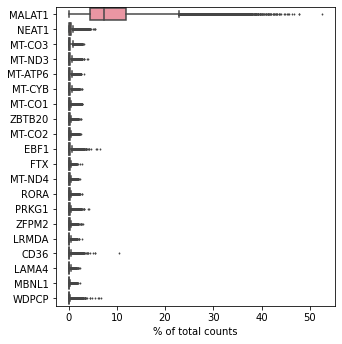

In [232]:
sc.pl.highest_expr_genes(sn_adata, n_top=20, )

In [233]:
#filtering genes present in less than 3 cells:
#and cells with less than 200 genes
sc.pp.filter_cells(sn_adata, min_genes=200)
sc.pp.filter_genes(sn_adata, min_cells=3)

/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical


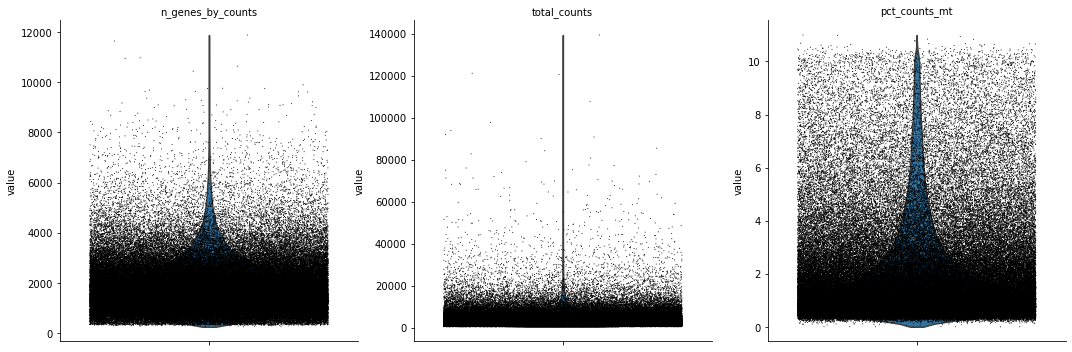

In [234]:
# remove genes with high mitochondrial content
sn_adata.var['mt'] = sn_adata.var_names.str.startswith('MT')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(sn_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(sn_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

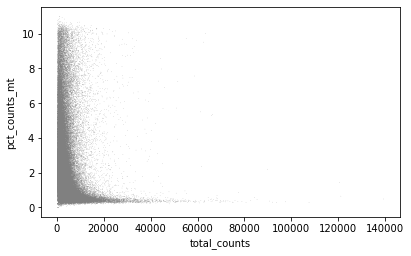

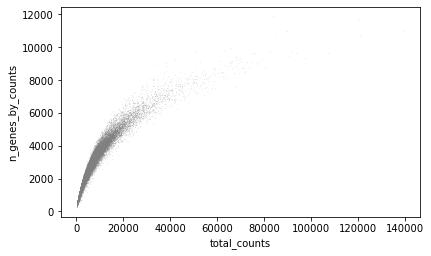

In [235]:
sc.pl.scatter(sn_adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(sn_adata, x='total_counts', y='n_genes_by_counts')

In [236]:
sn_adata = sn_adata[sn_adata.obs.n_genes_by_counts < 6000, :]
sn_adata = sn_adata[sn_adata.obs.pct_counts_mt < 5, :]

In [237]:
#making copy to keep unnormalized for export
sn_adata_copy = sn_adata.copy()

In [238]:
# normalize to 10K counts per cell
sc.pp.normalize_total(sn_adata, target_sum=1e4)
#logging local adata
sc.pp.log1p(sn_adata)

/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


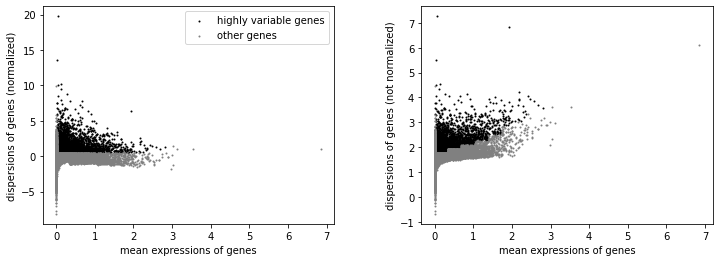

In [239]:
highly_var_genes = sc.pp.highly_variable_genes(sn_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(sn_adata)

Assigning cell types:

In [240]:
# Merge the two DataFrames based on the indexes from before
merged_df = pd.merge(sn_adata.obs, cell_meta, left_index=True, right_index=True)
merged_df

,n_genes_x,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,cell_id,biosample_id,biosample_type,library_preparation_protocol__ontology_id,library_preparation_protocol__ontology_label,...,ribosomal_protein_percent,sct__n_umis,sct__n_genes,cell_cycle__s_score,cell_cycle__g2m_score,cell_cycle__phase,cell_type__ontology_id,cell_type__ontology_label,cell_type__custom,cell_subtype__custom
Hs_OAT_12-1_AAACCCAAGCACAAAT,523,523,622.0,25.0,4.019292,Hs_OAT_12-1_AAACCCAAGCACAAAT,Hs_OAT_12-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,...,1.286174,1401,556,0.007643,0.030800,G2M,CL:0002334,preadipocyte,ASPC,hASPC1
Hs_OAT_12-1_AAACCCAAGCGTATGG,866,866,1231.0,58.0,4.711617,Hs_OAT_12-1_AAACCCAAGCGTATGG,Hs_OAT_12-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,...,0.649878,1762,866,-0.018428,0.010609,G2M,CL:0000077,mesothelial cell,mesothelium,hMes2
Hs_OAT_12-1_AAACCCAAGCTCGTGC,1023,1023,1309.0,19.0,1.451490,Hs_OAT_12-1_AAACCCAAGCTCGTGC,Hs_OAT_12-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,...,1.069519,1681,1023,-0.026009,-0.015240,G1,CL:0000077,mesothelial cell,mesothelium,hMes1
Hs_OAT_12-1_AAACCCAAGTGGATAT,1516,1516,2154.0,93.0,4.317549,Hs_OAT_12-1_AAACCCAAGTGGATAT,Hs_OAT_12-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,...,0.510678,2160,1516,-0.026939,0.031461,G2M,CL:0000669,pericyte cell,pericyte,hPeri
Hs_OAT_12-1_AAACCCAAGTTCGCAT,1666,1666,3549.0,42.0,1.183432,Hs_OAT_12-1_AAACCCAAGTTCGCAT,Hs_OAT_12-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,...,0.309946,2692,1666,-0.011481,-0.013545,G1,CL:0000136,fat cell,adipocyte,hAd2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Hs_SAT_11-1_TTTGGAGTCGACGAGA,2479,2479,5314.0,230.0,4.328190,Hs_SAT_11-1_TTTGGAGTCGACGAGA,Hs_SAT_11-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,...,0.338728,3560,2341,-0.005544,-0.007437,G1,CL:0002334,preadipocyte,ASPC,hASPC2
Hs_SAT_11-1_TTTGGAGTCTCCGATC,1813,1813,3184.0,58.0,1.821608,Hs_SAT_11-1_TTTGGAGTCTCCGATC,Hs_SAT_11-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,...,0.251256,3066,1811,0.008630,0.010638,G2M,CL:0002334,preadipocyte,ASPC,hASPC5
Hs_SAT_11-1_TTTGGTTAGTGATGGC,4520,4520,17086.0,50.0,0.292637,Hs_SAT_11-1_TTTGGTTAGTGATGGC,Hs_SAT_11-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,...,0.163877,2913,1778,-0.006596,-0.022388,G1,CL:0000136,fat cell,adipocyte,hAd4
Hs_SAT_11-1_TTTGGTTTCATGCCAA,1171,1171,1758.0,39.0,2.218430,Hs_SAT_11-1_TTTGGTTTCATGCCAA,Hs_SAT_11-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,...,0.000000,2255,1171,0.001052,-0.011141,S,CL:0000136,fat cell,adipocyte,hAd2


In [241]:
# Extract the cell type labels from the merged DataFrame
cell_type_labels = merged_df["cell_type__ontology_label"]

# Assign the cell type labels to the adata.obs DataFrame
sn_adata.obs["cell_types"] = cell_type_labels
sn_adata_copy.obs["cell_types"] = cell_type_labels
sn_adata_copy.var["highly_var_genes"] = sn_adata.var["highly_variable"]

In [242]:
####QC### celltype assignments:  
sn_adata['Hs_OAT_12-1_AAACCCAAGCACAAAT'].obs["cell_types"] == cell_meta["cell_type__ontology_label"]['Hs_OAT_12-1_AAACCCAAGCACAAAT']

Hs_OAT_12-1_AAACCCAAGCACAAAT    True
Name: cell_types, dtype: bool

In [244]:
#saving for later adata as anndata without normalization
adata_path = os.path.join(aug_data_path, f"{res_name}_adata_notlog.h5ad")
adata_path = Path(adata_path)
sn_adata_copy.write_h5ad(adata_path)

/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_types' as categorical


: 

         Falling back to preprocessing with `sc.pp.pca` and default params.


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_types' as categorical


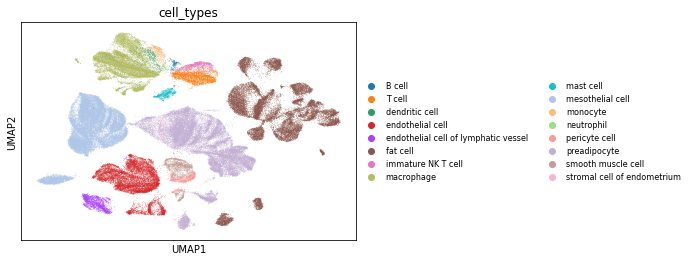

In [26]:
# calculate neighborhood graph
sc.pp.neighbors(sn_adata)

# make umap
sc.tl.umap(sn_adata)

# plot some markers of the RAW data
sc.pl.umap(sn_adata, color='cell_types', legend_fontsize=8)

In [27]:
Counter(sn_adata.obs["cell_types"]) #all cell types counted

Counter({'preadipocyte': 28725,
         'mesothelial cell': 27412,
         'pericyte cell': 1255,
         'fat cell': 24999,
         'macrophage': 14543,
         'endothelial cell': 12657,
         'endothelial cell of lymphatic vessel': 2484,
         'T cell': 3629,
         'dendritic cell': 764,
         'smooth muscle cell': 2596,
         'B cell': 272,
         'mast cell': 962,
         'monocyte': 820,
         'immature NK T cell': 1301,
         'stromal cell of endometrium': 295,
         'neutrophil': 94})

Interesection File:

In [28]:
# write out the gene ids in intersection file
genes_all = sn_adata.var["gene_ids"]
gene_out_file = os.path.join(aug_data_path, "intersection_genes.pkl")
gene_out_path = Path(gene_out_file)
pickle.dump( genes_all, open(gene_out_path, "wb" ) )

And Pseudobulk-creating loops:
1. 5 Cell Types only, All noise added
2. 5 Cell Types only, No noise added
3. All Cell Types, All noise added
4. All Cell Types, No noise added
5. All Cell Types, No sample noise added (other noise is added)

Run all or one at a time as needed.

In [29]:
exclude = ['preadipocyte',
    'mesothelial cell',
    'pericyte cell',
    'fat cell',
    'endothelial cell',
    'endothelial cell of lymphatic vessel',
    'smooth muscle cell',
    'mast cell',
    'immature NK T cell',
    'stromal cell of endometrium',
    'neutrophil']
sn_adata_cut = sn_adata_copy[~sn_adata_copy.obs["cell_types"].isin(exclude), :]
#Tilde is “not”, so this reads like “var names that are not in exclude”
Counter(sn_adata_cut.obs["cell_types"])

Counter({'macrophage': 14543,
         'T cell': 3629,
         'dendritic cell': 764,
         'B cell': 272,
         'monocyte': 820})

In [30]:
# no specific cell noise 
sn_adata_cut.obs["scpred_CellType"] = sn_adata_cut.obs["cell_types"]
len_vector = sn_adata_cut.obs["cell_types"].unique().shape[0]
cell_noise = [np.random.lognormal(0, 0, sn_adata_cut.var['gene_ids'].shape[0]) for i in range(len_vector)]

# cell type order
cell_order = sn_adata_cut.obs.cell_types.unique()
#custom proportion of equal prop / cell
num_cells = len_vector
custom_prop = np.array([(1/num_cells)]*num_cells)
custom_prop  =  pd.DataFrame(custom_prop).T
custom_prop.columns = cell_order
custom_prop

Trying to set attribute `.obs` of view, copying.


,macrophage,T cell,dendritic cell,B cell,monocyte
0,0.2,0.2,0.2,0.2,0.2


5 Cell Types, All Noise:

In [31]:
sampling_adata = sn_adata_cut
num_cells = 5000
num_random = 200
sample_noise = None #to create noise
if make_pseudos:  
        for idx in range(0,10):
                sample_noise = None
                print(f"**idx {idx}**")
                ###########################################################################################################
                ### CALC REALISTIC CELL TYPE PROPORTIONS AND CELL TYPE SPECIFIC
                ###########################################################################################################

                # calculate the reall cell type proportion
                curr_real_prop =  sn_sc_preprocess.calc_prop(sampling_adata, cell_order=cell_order)

                # make the cell type proportion matrix
                curr_prop_df = sn_sc_preprocess.get_corr_prop_matrix(num_samp=200, 
                                                                        real_prop=curr_real_prop.values.tolist()[0],
                                                                        cell_order=cell_order, 
                                                                        min_corr=0.95)
                # get the single cell type proportions
                ct_prop_df = sn_sc_preprocess.get_single_celltype_prop_matrix(num_samp=50,
                                                                                cell_order=cell_order)

                # put them together
                curr_prop_df = curr_prop_df.append(ct_prop_df)

                ########################################################
                ### MAKE PSEUDOBULKS FOR ^^^ PROPS 
                ########################################################
                # now get the pseudobulks for both realistic and cell type specific
                prop_df, pseudobulks_df, sample_noise = sn_sc_preprocess.use_prop_make_sum(sampling_adata,  
                                                                        num_cells=num_cells, 
                                                                        props_vec=curr_prop_df, 
                                                                        cell_noise=cell_noise, #no cell noise
                                                                        sample_noise=sample_noise)


                # make the proportions instead of cell counts
                prop_df = prop_df.div(prop_df.sum(axis=1), axis=0)
                
                ###########################################################################################################
                ######   NOW THE RANDOM PROPS AND PSEUDOS  ############################
                ###########################################################################################################
                
                prop_df_new, pseudobulk_df_new, test_prop, test_expr =  sn_sc_preprocess.make_prop_and_sum(sampling_adata, 
                                                                        num_samples = num_random, 
                                                                        num_cells = num_cells, 
                                                                        use_true_prop = False, 
                                                                        cell_noise = cell_noise, #no cell noise
                                                                        sample_noise = sample_noise)
                                                                        
                # make the proportions instead of cell counts
                prop_df_new = prop_df_new.div(prop_df_new.sum(axis=1), axis=0)

                # put them together with the others
                prop_df = prop_df.append(prop_df_new)
                pseudobulks_df = pseudobulks_df.append(pseudobulk_df_new)

                ###########################################################################################################
                ### MAKE THE EQUAL PROPORTION PSEUDOS (almost equal)  ##############
                ###########################################################################################################

                # make the cell type proportion matrix  
                curr_prop_df_EQ = sn_sc_preprocess.get_prop_matrix_wnoise(custom_prop, num_bulks = 200)

                # now get the pseudobulks
                prop_df_EQ, pseudobulks_df_EQ, sample_noise = sn_sc_preprocess.use_prop_make_sum(sampling_adata,  
                                                                        num_cells=num_cells, 
                                                                        props_vec=curr_prop_df_EQ, 
                                                                        cell_noise=cell_noise, #no cell noise
                                                                        sample_noise=sample_noise)


                # make the proportions instead of cell counts
                prop_df_EQ = prop_df_EQ.div(prop_df_EQ.sum(axis=1), axis=0)

                # put them together with the rest of props and psuedos:
                prop_df = prop_df.append(prop_df_EQ)
                pseudobulks_df = pseudobulks_df.append(pseudobulks_df_EQ)

                ###########################################################################################################
                #######  SAVING   #################################################################################
                ###########################################################################################################

                pseudobulk_file = os.path.join(aug_data_path, f"{res_name}_5CTallnoise_pseudo_{idx}.pkl")
                prop_file = os.path.join(aug_data_path, f"{res_name}_5CTallnoise_prop_{idx}.pkl")

                pseudobulk_path = Path(pseudobulk_file)
                prop_path = Path(prop_file)

                pickle.dump( prop_df, open( prop_path, "wb" ) )
                pickle.dump( pseudobulks_df, open( pseudobulk_path, "wb" ) )

5 Cell Types, NO Noise:

In [32]:
sampling_adata = sn_adata_cut
num_cells = 5000
num_random = 200
sample_noise = "No noise"
if make_pseudos:  
        for idx in range(0,10):
                sample_noise = "No noise"
                print(f"**idx {idx}**")
                ###########################################################################################################
                ### CALC REALISTIC CELL TYPE PROPORTIONS AND CELL TYPE SPECIFIC
                ###########################################################################################################

                # calculate the reall cell type proportion
                curr_real_prop =  sn_sc_preprocess.calc_prop(sampling_adata, cell_order=cell_order)

                # make the cell type proportion matrix
                curr_prop_df = sn_sc_preprocess.get_corr_prop_matrix(num_samp=200, 
                                                                        real_prop=curr_real_prop.values.tolist()[0],
                                                                        cell_order=cell_order, 
                                                                        min_corr=0.95)
                # get the single cell type proportions
                ct_prop_df = sn_sc_preprocess.get_single_celltype_prop_matrix(num_samp=50,
                                                                                cell_order=cell_order)

                # put them together
                curr_prop_df = curr_prop_df.append(ct_prop_df)

                ########################################################
                ### MAKE PSEUDOBULKS FOR ^^^ PROPS 
                ########################################################
                # now get the pseudobulks for both realistic and cell type specific
                prop_df, pseudobulks_df, sample_noise = sn_sc_preprocess.use_prop_make_sum(sampling_adata,  
                                                                        num_cells=num_cells, 
                                                                        props_vec=curr_prop_df, 
                                                                        cell_noise=cell_noise, #no cell noise
                                                                        sample_noise=sample_noise)

                sample_noise = "No noise"
                # make the proportions instead of cell counts
                prop_df = prop_df.div(prop_df.sum(axis=1), axis=0)
                
                ###########################################################################################################
                ######   NOW THE RANDOM PROPS AND PSEUDOS  ############################
                ###########################################################################################################
                
                prop_df_new, pseudobulk_df_new, test_prop, test_expr =  sn_sc_preprocess.make_prop_and_sum(sampling_adata, 
                                                                        num_samples = num_random, 
                                                                        num_cells = num_cells, 
                                                                        use_true_prop = False, 
                                                                        cell_noise = cell_noise, #no cell noise
                                                                        sample_noise = sample_noise)
                                                                        
                # make the proportions instead of cell counts
                prop_df_new = prop_df_new.div(prop_df_new.sum(axis=1), axis=0)

                # put them together with the others
                prop_df = prop_df.append(prop_df_new)
                pseudobulks_df = pseudobulks_df.append(pseudobulk_df_new)

                ###########################################################################################################
                ### MAKE THE EQUAL PROPORTION PSEUDOS (almost equal)  ##############
                ###########################################################################################################

                # make the cell type proportion matrix  
                curr_prop_df_EQ = sn_sc_preprocess.get_prop_matrix_wnoise(custom_prop, num_bulks = 200)

                # now get the pseudobulks
                prop_df_EQ, pseudobulks_df_EQ, sample_noise = sn_sc_preprocess.use_prop_make_sum(sampling_adata,  
                                                                        num_cells=num_cells, 
                                                                        props_vec=curr_prop_df_EQ, 
                                                                        cell_noise=cell_noise, #no cell noise
                                                                        sample_noise=sample_noise)


                # make the proportions instead of cell counts
                prop_df_EQ = prop_df_EQ.div(prop_df_EQ.sum(axis=1), axis=0)

                # put them together with the rest of props and psuedos:
                prop_df = prop_df.append(prop_df_EQ)
                pseudobulks_df = pseudobulks_df.append(pseudobulks_df_EQ)

                ###########################################################################################################
                #######  SAVING   #################################################################################
                ###########################################################################################################

                pseudobulk_file = os.path.join(aug_data_path, f"{res_name}_5CTnonoise_pseudo_{idx}.pkl")
                prop_file = os.path.join(aug_data_path, f"{res_name}_5CTnonoise_prop_{idx}.pkl")

                pseudobulk_path = Path(pseudobulk_file)
                prop_path = Path(prop_file)

                pickle.dump( prop_df, open( prop_path, "wb" ) )
                pickle.dump( pseudobulks_df, open( pseudobulk_path, "wb" ) )

In [33]:
# no specific cell noise 
len_vector = sn_adata.obs["cell_types"].unique().shape[0]
cell_noise = [np.random.lognormal(0, 0, sn_adata.var['gene_ids'].shape[0]) for i in range(len_vector)]

# cell type order
cell_order = sn_adata.obs.cell_types.unique()
num_random = 200 #number of random pseudos

#adding cell types to both
sn_adata.obs['scpred_CellType'] = sn_adata.obs["cell_types"] #to match var name in functions
sn_adata_copy.obs['scpred_CellType'] = sn_adata.obs["cell_types"]

#custom proportion of equal prop / cell
num_cells = len_vector
custom_prop = np.array([(1/num_cells)]*num_cells)
custom_prop  =  pd.DataFrame(custom_prop).T
custom_prop.columns = cell_order
custom_prop

,preadipocyte,mesothelial cell,pericyte cell,fat cell,macrophage,endothelial cell,endothelial cell of lymphatic vessel,T cell,dendritic cell,smooth muscle cell,B cell,mast cell,monocyte,immature NK T cell,stromal cell of endometrium,neutrophil
0,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625,0.0625


All Cell Types, All Noise:

In [34]:
sampling_adata = sn_adata
num_cells = 5000
num_random = 200
sample_noise = None #to create noise
if make_pseudos:  
        for idx in range(0,10):
                sample_noise = None
                print(f"**idx {idx}**")
                ###########################################################################################################
                ### CALC REALISTIC CELL TYPE PROPORTIONS AND CELL TYPE SPECIFIC
                ###########################################################################################################

                # calculate the reall cell type proportion
                curr_real_prop =  sn_sc_preprocess.calc_prop(sampling_adata, cell_order=cell_order)

                # make the cell type proportion matrix
                curr_prop_df = sn_sc_preprocess.get_corr_prop_matrix(num_samp=200, 
                                                                        real_prop=curr_real_prop.values.tolist()[0],
                                                                        cell_order=cell_order, 
                                                                        min_corr=0.95)
                # get the single cell type proportions
                ct_prop_df = sn_sc_preprocess.get_single_celltype_prop_matrix(num_samp=50,
                                                                                cell_order=cell_order)

                # put them together
                curr_prop_df = curr_prop_df.append(ct_prop_df)

                ########################################################
                ### MAKE PSEUDOBULKS FOR ^^^ PROPS 
                ########################################################
                # now get the pseudobulks for both realistic and cell type specific
                prop_df, pseudobulks_df, sample_noise = sn_sc_preprocess.use_prop_make_sum(sampling_adata,  
                                                                        num_cells=num_cells, 
                                                                        props_vec=curr_prop_df, 
                                                                        cell_noise=cell_noise, #no cell noise
                                                                        sample_noise=sample_noise)


                # make the proportions instead of cell counts
                prop_df = prop_df.div(prop_df.sum(axis=1), axis=0)
                
                ###########################################################################################################
                ######   NOW THE RANDOM PROPS AND PSEUDOS  ############################
                ###########################################################################################################
                
                prop_df_new, pseudobulk_df_new, test_prop, test_expr =  sn_sc_preprocess.make_prop_and_sum(sampling_adata, 
                                                                        num_samples = num_random, 
                                                                        num_cells = num_cells, 
                                                                        use_true_prop = False, 
                                                                        cell_noise = cell_noise, #no cell noise
                                                                        sample_noise = sample_noise)
                                                                        
                # make the proportions instead of cell counts
                prop_df_new = prop_df_new.div(prop_df_new.sum(axis=1), axis=0)

                # put them together with the others
                prop_df = prop_df.append(prop_df_new)
                pseudobulks_df = pseudobulks_df.append(pseudobulk_df_new)

                ###########################################################################################################
                ### MAKE THE EQUAL PROPORTION PSEUDOS (almost equal)  ##############
                ###########################################################################################################

                # make the cell type proportion matrix  
                curr_prop_df_EQ = sn_sc_preprocess.get_prop_matrix_wnoise(custom_prop, num_bulks = 200)

                # now get the pseudobulks
                prop_df_EQ, pseudobulks_df_EQ, sample_noise = sn_sc_preprocess.use_prop_make_sum(sampling_adata,  
                                                                        num_cells=num_cells, 
                                                                        props_vec=curr_prop_df_EQ, 
                                                                        cell_noise=cell_noise, #no cell noise
                                                                        sample_noise=sample_noise)


                # make the proportions instead of cell counts
                prop_df_EQ = prop_df_EQ.div(prop_df_EQ.sum(axis=1), axis=0)

                # put them together with the rest of props and psuedos:
                prop_df = prop_df.append(prop_df_EQ)
                pseudobulks_df = pseudobulks_df.append(pseudobulks_df_EQ)

                ###########################################################################################################
                #######  SAVING   #################################################################################
                ###########################################################################################################

                pseudobulk_file = os.path.join(aug_data_path, f"{res_name}_allnoise_pseudo_{idx}.pkl")
                prop_file = os.path.join(aug_data_path, f"{res_name}_allnoise_prop_{idx}.pkl")

                pseudobulk_path = Path(pseudobulk_file)
                prop_path = Path(prop_file)

                pickle.dump( prop_df, open( prop_path, "wb" ) )
                pickle.dump( pseudobulks_df, open( pseudobulk_path, "wb" ) )

All Cell Types, No Noise:

In [35]:
sampling_adata = sn_adata_copy
num_cells = 5000
num_random = 200
sample_noise = "No noise"
if make_pseudos:  
        for idx in range(0,10):
                sample_noise = "No noise"
                print(f"**idx {idx}**")
                ###########################################################################################################
                ### CALC REALISTIC CELL TYPE PROPORTIONS AND CELL TYPE SPECIFIC
                ###########################################################################################################

                # calculate the reall cell type proportion
                curr_real_prop =  sn_sc_preprocess.calc_prop(sampling_adata, cell_order=cell_order)

                # make the cell type proportion matrix
                curr_prop_df = sn_sc_preprocess.get_corr_prop_matrix(num_samp=200, 
                                                                        real_prop=curr_real_prop.values.tolist()[0],
                                                                        cell_order=cell_order, 
                                                                        min_corr=0.95)
                # get the single cell type proportions
                ct_prop_df = sn_sc_preprocess.get_single_celltype_prop_matrix(num_samp=50,
                                                                                cell_order=cell_order)

                # put them together
                curr_prop_df = curr_prop_df.append(ct_prop_df)

                ########################################################
                ### MAKE PSEUDOBULKS FOR ^^^ PROPS 
                ########################################################
                # now get the pseudobulks for both realistic and cell type specific
                prop_df, pseudobulks_df, sample_noise = sn_sc_preprocess.use_prop_make_sum(sampling_adata,  
                                                                        num_cells=num_cells, 
                                                                        props_vec=curr_prop_df, 
                                                                        cell_noise=cell_noise, #no cell noise
                                                                        sample_noise=sample_noise)

                sample_noise = "No noise"
                # make the proportions instead of cell counts
                prop_df = prop_df.div(prop_df.sum(axis=1), axis=0)
                
                ###########################################################################################################
                ######   NOW THE RANDOM PROPS AND PSEUDOS  ############################
                ###########################################################################################################
                
                prop_df_new, pseudobulk_df_new, test_prop, test_expr =  sn_sc_preprocess.make_prop_and_sum(sampling_adata, 
                                                                        num_samples = num_random, 
                                                                        num_cells = num_cells, 
                                                                        use_true_prop = False, 
                                                                        cell_noise = cell_noise, #no cell noise
                                                                        sample_noise = sample_noise)
                                                                        
                # make the proportions instead of cell counts
                prop_df_new = prop_df_new.div(prop_df_new.sum(axis=1), axis=0)

                # put them together with the others
                prop_df = prop_df.append(prop_df_new)
                pseudobulks_df = pseudobulks_df.append(pseudobulk_df_new)

                ###########################################################################################################
                ### MAKE THE EQUAL PROPORTION PSEUDOS (almost equal)  ##############
                ###########################################################################################################

                # make the cell type proportion matrix  
                curr_prop_df_EQ = sn_sc_preprocess.get_prop_matrix_wnoise(custom_prop, num_bulks = 200)

                # now get the pseudobulks
                prop_df_EQ, pseudobulks_df_EQ, sample_noise = sn_sc_preprocess.use_prop_make_sum(sampling_adata,  
                                                                        num_cells=num_cells, 
                                                                        props_vec=curr_prop_df_EQ, 
                                                                        cell_noise=cell_noise, #no cell noise
                                                                        sample_noise=sample_noise)


                # make the proportions instead of cell counts
                prop_df_EQ = prop_df_EQ.div(prop_df_EQ.sum(axis=1), axis=0)

                # put them together with the rest of props and psuedos:
                prop_df = prop_df.append(prop_df_EQ)
                pseudobulks_df = pseudobulks_df.append(pseudobulks_df_EQ)

                ###########################################################################################################
                #######  SAVING   #################################################################################
                ###########################################################################################################

                pseudobulk_file = os.path.join(aug_data_path, f"{res_name}_nonoise_pseudo_{idx}.pkl")
                prop_file = os.path.join(aug_data_path, f"{res_name}_nonoise_prop_{idx}.pkl")

                pseudobulk_path = Path(pseudobulk_file)
                prop_path = Path(prop_file)

                pickle.dump( prop_df, open( prop_path, "wb" ) )
                pickle.dump( pseudobulks_df, open( pseudobulk_path, "wb" ) )

All Cell Types, No Sample Noise:

In [36]:
sampling_adata = sn_adata_copy
num_cells = 5000
num_random = 200
sample_noise = "No sample noise"
if make_pseudos:  
        for idx in range(0,10):
                sample_noise = "No sample noise"
                print(f"**idx {idx}**")
                ###########################################################################################################
                ### CALC REALISTIC CELL TYPE PROPORTIONS AND CELL TYPE SPECIFIC
                ###########################################################################################################

                # calculate the reall cell type proportion
                curr_real_prop =  sn_sc_preprocess.calc_prop(sampling_adata, cell_order=cell_order)

                # make the cell type proportion matrix
                curr_prop_df = sn_sc_preprocess.get_corr_prop_matrix(num_samp=200, 
                                                                        real_prop=curr_real_prop.values.tolist()[0],
                                                                        cell_order=cell_order, 
                                                                        min_corr=0.95)
                # get the single cell type proportions
                ct_prop_df = sn_sc_preprocess.get_single_celltype_prop_matrix(num_samp=50,
                                                                                cell_order=cell_order)

                # put them together
                curr_prop_df = curr_prop_df.append(ct_prop_df)

                ########################################################
                ### MAKE PSEUDOBULKS FOR ^^^ PROPS 
                ########################################################
                # now get the pseudobulks for both realistic and cell type specific
                prop_df, pseudobulks_df, sample_noise = sn_sc_preprocess.use_prop_make_sum(sampling_adata,  
                                                                        num_cells=num_cells, 
                                                                        props_vec=curr_prop_df, 
                                                                        cell_noise=cell_noise, #no cell noise
                                                                        sample_noise=sample_noise)
                sample_noise = "No sample noise"

                # make the proportions instead of cell counts
                prop_df = prop_df.div(prop_df.sum(axis=1), axis=0)
                
                ###########################################################################################################
                ######   NOW THE RANDOM PROPS AND PSEUDOS  ############################
                ###########################################################################################################
                
                prop_df_new, pseudobulk_df_new, test_prop, test_expr =  sn_sc_preprocess.make_prop_and_sum(sampling_adata, 
                                                                        num_samples = num_random, 
                                                                        num_cells = num_cells, 
                                                                        use_true_prop = False, 
                                                                        cell_noise = cell_noise, #no cell noise
                                                                        sample_noise = sample_noise)
                                                                        
                # make the proportions instead of cell counts
                prop_df_new = prop_df_new.div(prop_df_new.sum(axis=1), axis=0)

                # put them together with the others
                prop_df = prop_df.append(prop_df_new)
                pseudobulks_df = pseudobulks_df.append(pseudobulk_df_new)

                ###########################################################################################################
                ### MAKE THE EQUAL PROPORTION PSEUDOS (almost equal)  ##############
                ###########################################################################################################

                # make the cell type proportion matrix  
                curr_prop_df_EQ = sn_sc_preprocess.get_prop_matrix_wnoise(custom_prop, num_bulks = 200)

                # now get the pseudobulks
                prop_df_EQ, pseudobulks_df_EQ, sample_noise = sn_sc_preprocess.use_prop_make_sum(sampling_adata,  
                                                                        num_cells=num_cells, 
                                                                        props_vec=curr_prop_df_EQ, 
                                                                        cell_noise=cell_noise, #no cell noise
                                                                        sample_noise=sample_noise)


                # make the proportions instead of cell counts
                prop_df_EQ = prop_df_EQ.div(prop_df_EQ.sum(axis=1), axis=0)

                # put them together with the rest of props and psuedos:
                prop_df = prop_df.append(prop_df_EQ)
                pseudobulks_df = pseudobulks_df.append(pseudobulks_df_EQ)

                ###########################################################################################################
                #######  SAVING   #################################################################################
                ###########################################################################################################

                pseudobulk_file = os.path.join(aug_data_path, f"{res_name}_nosampnoise_pseudo_{idx}.pkl")
                prop_file = os.path.join(aug_data_path, f"{res_name}_nosampnoise_prop_{idx}.pkl")

                pseudobulk_path = Path(pseudobulk_file)
                prop_path = Path(prop_file)

                pickle.dump( prop_df, open( prop_path, "wb" ) )
                pickle.dump( pseudobulks_df, open( pseudobulk_path, "wb" ) )

In [37]:
#saving for later adata as df
adata_df = pd.DataFrame(sn_adata_copy.X.toarray(), columns = sn_adata_copy.var["gene_ids"].values)
adata_path = os.path.join(aug_data_path, f"{res_name}_adata_df.pkl")
adata_path = Path(adata_path)
pickle.dump( adata_df, open( adata_path, "wb" ) ) 

QC Pseudobulks Made:

In [179]:
X_full, Y_full, gene_df, meta_df= sn_sc_preprocess.read_all_pseudobulk_files(data_path=aug_data_path, noise_type="allnoise_", file_name = res_name, num_bulks_training = 100, num_files=1)

0


(100, 2)
(100, 2)


/var/folders/d3/x10lxf7x1n37__s3n36qxmlw0000gp/T/ipykernel_20754/661164252.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


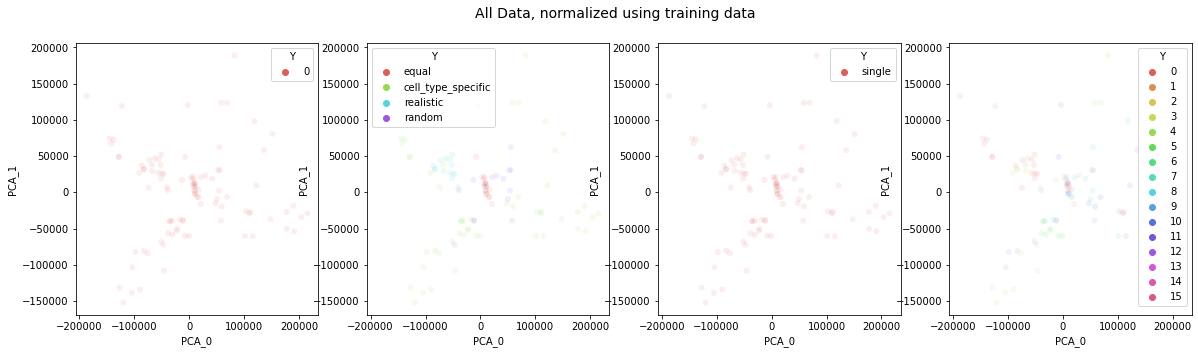

In [180]:
## plot samples
#idx_interest = np.where(meta_df.samp_type == "single")[0]

plot_df = vp.get_pca_for_plotting(X_full)

fig, axs = plt.subplots(1, 4, figsize=(20,5))

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_pca(plot_df, meta_df.sample_id.to_numpy(), axs[0], title=f"")
vp.plot_pca(plot_df, meta_df.cell_prop_type.to_numpy(), axs[1], title=f"")
vp.plot_pca(plot_df, meta_df.samp_type.to_numpy(), axs[2], title=f"")
vp.plot_pca(plot_df, Y_temp, axs[3], title=f"")


fig.suptitle("All Data, normalized using training data", fontsize=14)

fig.show()

/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.001s...
[t-SNE] Computed neighbors for 100 samples in 0.047s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 63955.519236
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.187180
[t-SNE] KL divergence after 500 iterations: 0.651621
(100, 2)
(100, 2)


/var/folders/d3/x10lxf7x1n37__s3n36qxmlw0000gp/T/ipykernel_20754/1906434642.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


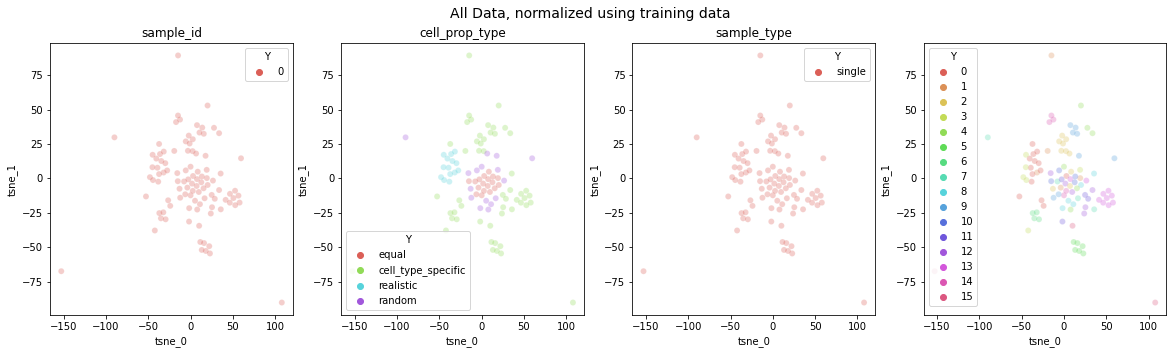

In [181]:
## plot samples
plot_df = vp.get_tsne_for_plotting(X_full)

fig, axs = plt.subplots(1, 4, figsize=(20,5))

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_tsne(plot_df, meta_df.sample_id.to_numpy(), axs[0], title=f"sample_id")
vp.plot_tsne(plot_df, meta_df.cell_prop_type.to_numpy(), axs[1], title=f"cell_prop_type")
vp.plot_tsne(plot_df, meta_df.samp_type.to_numpy(), axs[2], title=f"sample_type")
vp.plot_tsne(plot_df, Y_temp, axs[3], title=f"")

fig.suptitle("All Data, normalized using training data", fontsize=14)

fig.show()

CibersortX Preparation:

In [182]:
#and as anndata object
adata_path = os.path.join(aug_data_path, f"{res_name}_adata_notlog.h5ad")
adata_path = Path(adata_path)
sn_adata_copy = sc.read_h5ad(adata_path)
Counter(sn_adata_copy.obs.cell_types)

AnnData object with n_obs × n_vars = 122808 × 28189
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_types'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_var_genes'

Deleting cells in large cell types to be able to run CibersortX:
(data is too large)

In [184]:
# Define the cell types you want to limit and the desired maximum number of cells
cell_types_to_limit = ["preadipocyte", "mesothelial cell", "fat cell", "macrophage", "pericyte", 
                            "endothelial cell", "pericyte cell", "endothelial cell of lymphatic vessel", 
                            "T cell", "smooth muscle cell", "immature NK T cell"]
max_cells_per_type = 550

# Create a mask to identify cells from the cell types you want to limit
mask_to_limit = sn_adata_copy.obs["cell_types"].isin(cell_types_to_limit)

# Create a mask for the remaining cell types
mask_remaining = ~mask_to_limit

# Initialize a dictionary to keep track of removed cells per cell type
removed_cells_count = {cell_type: 0 for cell_type in cell_types_to_limit}

# Initialize arrays to store new observations and filtered indices
new_obs = []
filtered_indices = []

# Iterate through each cell in the original Anndata object
for cell_idx, cell_type in enumerate(sn_adata_copy.obs["cell_types"]):
    if cell_type in cell_types_to_limit:
        removed_count = removed_cells_count.get(cell_type, 0)
        if removed_count < max_cells_per_type:
            removed_cells_count[cell_type] = removed_count + 1
            filtered_indices.append(cell_idx)

# Create a new AnnData object with the filtered cells
filtered_sn_adata = sc.AnnData(
    X=sn_adata_copy.X[filtered_indices],
    obs=sn_adata_copy.obs.iloc[filtered_indices],
    var=sn_adata_copy.var
)

# Append the remaining cell types to the filtered AnnData object
filtered_sn_adata = filtered_sn_adata.concatenate(
    sn_adata_copy[mask_remaining],
    join="outer"
)
Counter(filtered_sn_adata.obs.cell_types)

In [186]:
dense_matrix = filtered_sn_adata.X.todense()

sc_profile_file = os.path.join(aug_data_path, f"{res_name}_sig.pkl")
sc_profile_path = Path(sc_profile_file)

dense_df = pd.DataFrame(dense_matrix, columns = filtered_sn_adata.var['gene_ids'])
dense_df.insert(loc=0, column='cell_types', value=filtered_sn_adata.obs["cell_types"].to_list())
#save file
pickle.dump( dense_df, open( sc_profile_path, "wb" ) )
#qc
sig_df_sn = dense_df
sig_df_sn.shape

(8707, 28190)

In [187]:
#cut to only the random samples
X_full.index = meta_df.index

In [188]:
# # now we import all bulks and transpose
X_train = X_full.transpose()
X_train.columns = range(X_train.shape[1])

In [193]:
#details
exp_id = "EXP1_randomprop"
patient_idx = "pt0"
#and create files for CIBERSORTX
mix_sn, sig_sn = vp.write_cs_bp_files(cibersort_path, exp_id, sig_df_sn, X_train, patient_idx)